# Pole-Zero (PZ) simulation example

In this short example we will simulate a simple [RLC circuit](https://en.wikipedia.org/wiki/RLC_circuit) with the [ahkab](https://ahkab.github.io/ahkab/) simulator.

In particular, we consider a series resonant RLC circuit. If you need to refresh your knowledge on 2nd filters, you may [take a look at this page](http://hyperphysics.phy-astr.gsu.edu/hbase/electric/serres.html).

## The plan: what we'll do

### 0. A brief analysis of the circuit

This should be done with pen and paper, we'll just mention the results. The circuit is pretty simple, feel free to skip if you find it boring.

### 1. How to describe the circuit with ahkab

We'll show this:

* from Python,
* and briefly with a netlist deck.

### 2. Pole-zero analysis

* We will extract poles and zeros.
* We'll use them to build input-output transfer function, which we evaluate.

### 3. AC analysis

* We will run an AC analysis to evaluate numerically the transfer function.

### 4. Symbolic analysis

* We'll finally run a symbolic analysis as well.
* Once we have the results, we'll substitute for the real circuit values and verify both AC and PZ analysis.

### 5. Conclusions

We will check that the three PZ, AC and Symbolic analysis match!

## The circuit

The circuit we simulate is a very simple one:

INSERT

## 0. Theory

Once one proves that the current flowing in the only circuit branch in the Laplace domain is given by:

$$I(s) = \frac{1}{L}\cdot\frac{s}{s^2 + 2\alpha\cdot s + \omega_0^2}$$

Where:

* $s$ is the Laplace varible, $s = \sigma + j \omega$:
    * $j$ is the imaginary unit,
    * $\omega$ is the angular frequency (units rad/s).
* $\alpha$ is known as the *Neper frequency* and it is given by $R/(2L)$,
* $\omega_0$ is the *(undamped) resonance frequency, equal to $(\sqrt{LC})^{-1}$.

It's easy to show that the pass-band transfer function we consider in our circuit, $V_{OUT}/V_{IN}$, has the expression:

$$H(s) = \frac{V_{OUT}}{V_{IN}}(s) = k_0 \cdot\frac{s}{s^2 + 2\alpha\cdot s + \omega_0^2}$$

Where the coeffiecient $k_0$ has value $k_0 = R/L$.

Solving for poles and zeros, we get:

* One zero:
    * $z_0$, located in the origin.
* Two poles, $p_0$ and $p_1$:
    * $p_{0,1} = - \alpha \pm \sqrt{\alpha^2 - \omega_0^2}$

## 1. Describe the circuit with ahkab

Let's call `ahkab` and describe the circuit above.

First we need to import `ahkab`:

In [1]:
%pylab inline
figsize = (10, 7)
# libraries we need
import ahkab

Populating the interactive namespace from numpy and matplotlib


In [2]:
print "We're using ahkab %s" % ahkab.__version__

We're using ahkab 0.16


Then we create a new circuit object titled 'RLC bandpass', which we name `bpf` from Band-Pass Filter:

In [3]:
bpf = ahkab.Circuit('RLC bandpass')

A circuit is made of, internally, components and nodes. For now, our `bpf` circuit is empty and really of not much use.

We wish to define our nodes, our components, specifying their connection to the appropriate nodes and inform the circuit instance about the what we did.

It sounds complicated, but it is actually very simple, also thanks to the convenience functions `add_*()` in the `Circuit` instances ([circuit documentation](https://ahkab.readthedocs.org/en/latest/circuit.html)).

We now add the inductor `L1`, the capacitor `C1`, the resistor `R1` and the input source `V1`:

In [4]:
bpf = ahkab.Circuit('RLC bandpass')
bpf.add_inductor('L1', 'in', 'n1', 1e-6)
bpf.add_capacitor('C1', 'n1', 'out', 2.2e-12)
bpf.add_resistor('R1', 'out', bpf.gnd, 13)
# we also give V1 an AC value since we wish to run an AC simulation
# in the following
bpf.add_vsource('V1', 'in', bpf.gnd, dc_value=1, ac_value=1)

Notice that:
* the nodes to which they get connected (`'in'`, `'n1'`, `'out'`...) are nothing but strings. If you prefer handles, you can call the `create_node()` method of the circuit instance `bpf` ([create_node documentation](https://ahkab.readthedocs.org/en/latest/circuit.html#ahkab.circuit.Circuit.create_node).
* Using the convenience methods `add_*`, the nodes are not explicitely added to the circuit, but they are in fact automatically taken care of behind the hood.

Now we have successfully defined our circuit object `bpf`.

Let's see what's in there and generate a netlist:

In [5]:
print(bpf)

* RLC bandpass
L1 in n1 1e-06
C1 n1 out 2.2e-12
R1 out 0 13
V1 in 0 type=vdc value=1 vac=1 


The above text defines the same circuit in netlist form. It has the advantage that it's a very coincise piece of text and that the syntax resembles (not perfectly yet) that of simulators such as [SPICE](https://newton.ex.ac.uk/teaching/CDHW/Electronics2/userguide/).

If you prefer to run `ahkab` from the command line, be sure to check the [Netlist syntax doc page](https://ahkab.readthedocs.org/en/latest/help/Netlist-Syntax.html) and to add the simulation statements, which are missing above.

## 2. PZ analysis

The analysis is set up easily by calling `ahkab.new_pz()`. Its signature is:

    ahkab.new_pz(input_source=None, output_port=None, shift=0.0, MNA=None, outfile=None, x0=u'op', verbose=0)
    
And you can find [the documentation for ahkab.new_pz here](https://ahkab.readthedocs.org/en/latest/ahkab.html#ahkab.ahkab.new_pz).
    
We will set:
* Input source and output port, to enable the extraction of the zeros.
    * the input source is `V1`,
    * the output port is defined between the output node `out` and ground node (`bpf.gnd`).
* We need no linearization, since the circuit is linear. Therefore we set `x0` to `None`.
* I inserted a non-zero shift in the initial calculation frequency below. You may want to fiddle a bit with this value, the algorithm internally tries to kick the working frequency away from the exact location of the zeros, since we expect a zero in the origin, we help the simulation find the zero quickly by shifting away the initial working point.

In [6]:
pza = ahkab.new_pz('V1', ('out', bpf.gnd), x0=None, shift=1e3)
r = ahkab.run(bpf, pza)['pz']

The results are in the `pz_solution` object `r`. It has an interface that works like a dictionary.

Eg. you can do:

In [7]:
r.keys()

[u'p0', u'p1', u'z0']

Check out the [documentation on pz_solution for more](https://ahkab.readthedocs.org/en/latest/results.html#ahkab.results.pz_solution).

Let's see what we got:

In [8]:
print('Singularities:')
for x, _ in r:
    print "* %s = %+g %+gj Hz" % (x, np.real(r[x]), np.imag(r[x]))

Singularities:
* p0 = -1.03451e+06 -1.07297e+08j Hz
* p1 = -1.03451e+06 +1.07297e+08j Hz
* z0 = -1.44751e-13 +0j Hz


**Note that the results are frequencies expressed in Hz** (and *not* angular frequencies in rad/s).

Graphically, we can see better where the singularities are located:

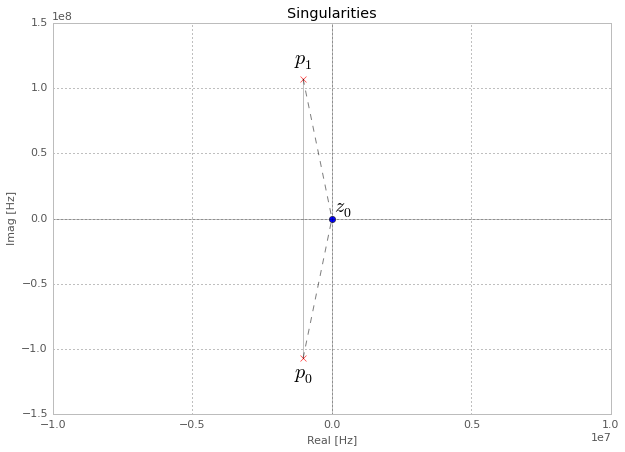

In [9]:
figure(figsize=figsize)
# plot o's for zeros and x's for poles
for x, v in r:
    plot(np.real(v), np.imag(v), 'bo'*(x[0]=='z')+'rx'*(x[0]=='p'))
# set axis limits and print some thin axes
xm = 1e6
xlim(-xm*10., xm*10.)
plot(xlim(), [0,0], 'k', alpha=.5, lw=.5)
plot([0,0], ylim(), 'k', alpha=.5, lw=.5)
# plot the distance from the origin of p0 and p1
plot([np.real(r['p0']), 0], [np.imag(r['p0']), 0], 'k--', alpha=.5)
plot([np.real(r['p1']), 0], [np.imag(r['p1']), 0], 'k--', alpha=.5)
# print the distance between p0 and p1
plot([np.real(r['p1']), np.real(r['p0'])], [np.imag(r['p1']), np.imag(r['p0'])], 'k-', alpha=.5, lw=.5)
# label the singularities
text(np.real(r['p1']), np.imag(r['p1'])*1.1, '$p_1$', ha='center', fontsize=20)
text(.4e6, .4e7, '$z_0$', ha='center', fontsize=20)
text(np.real(r['p0']), np.imag(r['p0'])*1.2, '$p_0$', ha='center', va='bottom', fontsize=20)
xlabel('Real [Hz]'); ylabel('Imag [Hz]'); title('Singularities');

As expected, we got two complex conjugate poles and a zero in the origin.

#### The resonance frequency

Let's check that indeed the (undamped) resonance frequency $f_0$ has the expected value from the theory.

It should be:

$$f_0 = \frac{1}{2\pi\sqrt{LC}}$$

Since we have little damping, $f_0$ is very close to the damped resonant frequency in our circuit, given by the absolute value of the imaginary part of either $p_0$ or $p_1$.

In fact, the damped resonant frequency $f_d$ is given by:

$$f_d = \frac{1}{2\pi}\sqrt{\alpha^2 -w_0^2}$$

Since this is an example and we have Python at our fingertips, we'll compensate for the frequency pulling due to the damping anyway. That way, the example is analytically correct.

In [10]:
C = 2.2e-12
L = 1e-6
f0 = 1./(2*np.pi*np.sqrt(L*C))
print 'Resonance frequency from analytic calculations: %g Hz' %f0

Resonance frequency from analytic calculations: 1.07302e+08 Hz


In [11]:
alpha = (-r['p0']-r['p1'])/2
a1 = np.real(abs(r['p0'] - r['p1']))/2
f0 = np.sqrt(a1**2 - alpha**2)
f0 = np.real_if_close(f0)
print 'Resonance frequency from PZ analysis: %g Hz' %f0

Resonance frequency from PZ analysis: 1.07292e+08 Hz


That's alright.

## 3. AC analysis

Let's perform an AC analysis:

In [12]:
aca = ahkab.new_ac(start=1e8, stop=5e9, points=5e2, x0=None)
rac = ahkab.run(bpf, aca)['ac']

Next, we use sympy to assemble the transfer functions from the singularities we got from the PZ analysis.

In [13]:
import sympy
sympy.init_printing()

In [14]:
from sympy.abc import w
from sympy import I
p0, p1, z0 = sympy.symbols('p0, p1, z0')
k = 13/1e-6 # constant term, can be calculated to be R/L
H = 13/1e-6*(I*w + z0*6.28)/(I*w +p0*6.28)/(I*w + p1*6.28)

In [15]:
Hl = sympy.lambdify(w, H.subs({p0:r['p0'], z0:abs(r['z0']), p1:r['p1']}))

We need a function to evaluate the absolute value of a transfer function in decibels.

Here it is:

In [16]:
def dB20(x):
    return 20*np.log10(x)

Next we can plot $|H(\omega)|$ in dB and inspect the results visually.

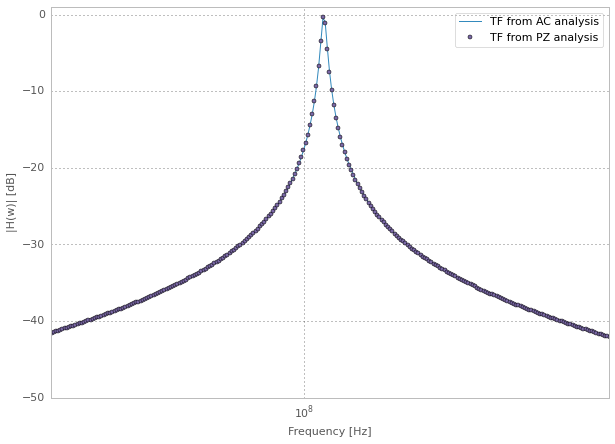

In [33]:
figure(figsize=figsize)
semilogx(rac.get_x()/2/np.pi, dB20(abs(rac['vout'])), label='TF from AC analysis')
semilogx(rac.get_x()/2/np.pi, dB20(abs(Hl(rac.get_x()))), 'o', ms=4, label='TF from PZ analysis')
legend(); xlabel('Frequency [Hz]'); ylabel('|H(w)| [dB]'); xlim(4e7, 3e8); ylim(-50, 1);

## 4. Symbolic analysis

Next, we setup and run a symbolic analysis. 

We set the input source to be `'V1'`, in this way, `ahkab` will calculate all transfer functions, together with low-frequency gain, poles and zeros, with respect to *every* variable in the circuit.

It is done very similarly to the previous cases:

In [18]:
symba = ahkab.new_symbolic(source='V1')
rs, tfs = ahkab.run(bpf, symba)['symbolic']

Notice how to the `'symbolic'` key corresponds a tuple of two objects: the symbolic results and the TF object that was derived from it.

Let's inspect their contents:

In [19]:
print(rs)

Symbolic simulation results for 'RLC bandpass' (netlist None).
Run on 2015-05-07 04:24:42.
I[L1]	 = C1*V1*s/(C1*L1*s**2 + C1*R1*s + 1.0)
I[V1]	 = -C1*V1*s/(C1*L1*s**2 + C1*R1*s + 1.0)
VIN	 = V1
VN1	 = V1*(C1*R1*s + 1.0)/(C1*L1*s**2 + C1*R1*s + 1.0)
VOUT	 = C1*R1*V1*s/(C1*L1*s**2 + C1*R1*s + 1.0)



In [20]:
print tfs

Symbolic transfer function results for 'RLC bandpass' (netlist None).
Run on 2015-05-07 04:24:42.
I[L1]/V1:
	gain:	C1*s/(C1*L1*s**2 + C1*R1*s + 1.0)
	gain0:	0
	poles:
		0.5*(-C1*R1 + sqrt(C1*(C1*R1**2 - 4.0*L1)))/(C1*L1)
		-0.5*(C1*R1 + sqrt(C1*(C1*R1**2 - 4.0*L1)))/(C1*L1)
	zeros:
		0
I[V1]/V1:
	gain:	-C1*s/(C1*L1*s**2 + C1*R1*s + 1.0)
	gain0:	0
	poles:
		0.5*(-C1*R1 + sqrt(C1*(C1*R1**2 - 4.0*L1)))/(C1*L1)
		-0.5*(C1*R1 + sqrt(C1*(C1*R1**2 - 4.0*L1)))/(C1*L1)
	zeros:
		0
VIN/V1:
	gain:	1
VN1/V1:
	gain:	(C1*R1*s + 1.0)/(C1*L1*s**2 + C1*R1*s + 1.0)
	gain0:	1.00000000000000
	poles:
		0.5*(-C1*R1 + sqrt(C1*(C1*R1**2 - 4.0*L1)))/(C1*L1)
		-0.5*(C1*R1 + sqrt(C1*(C1*R1**2 - 4.0*L1)))/(C1*L1)
	zeros:
		-1/(C1*R1)
VOUT/V1:
	gain:	C1*R1*s/(C1*L1*s**2 + C1*R1*s + 1.0)
	gain0:	0
	poles:
		0.5*(-C1*R1 + sqrt(C1*(C1*R1**2 - 4.0*L1)))/(C1*L1)
		-0.5*(C1*R1 + sqrt(C1*(C1*R1**2 - 4.0*L1)))/(C1*L1)
	zeros:
		0



In particular, to our transfer function corresponds:

In [21]:
tfs['VOUT/V1']

{u'gain': C1*R1*s/(C1*L1*s**2 + C1*R1*s + 1.0),
 u'gain0': 0,
 u'poles': [0.5*(-C1*R1 + sqrt(C1*(C1*R1**2 - 4.0*L1)))/(C1*L1),
  -0.5*(C1*R1 + sqrt(C1*(C1*R1**2 - 4.0*L1)))/(C1*L1)],
 u'zeros': [0]}

It's easy to show the above entries are a different formulation that corresponds to the theoretical results we introduced at the beginning of this example.

We'll do it graphically. First of all, let's isolate out TF:

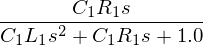

In [22]:
Hs = tfs['VOUT/V1']['gain']
Hs

We wish to substitute the correct circuit values to `R1`, `L1` and `C1` to be able to evaluate numerically the results.

In order to do so, the `symbolic_solution` class in the `results` module has a method named `as_symbols` that takes a string of space-separed symbol names and returns the `sympy` symbols associated with them ([symbolic_solution.as_symbols documentation](https://ahkab.readthedocs.org/en/latest/results.html#ahkab.results.symbolic_solution.as_symbols)).

In [23]:
s, C1, R1, L1 = rs.as_symbols('s C1 R1 L1')
HS = sympy.lambdify(w, Hs.subs({s:I*w, C1:2.2e-12, R1:13., L1:1e-6}))

Did we get the same results, let's sat within a 1dB accuracy?

In [24]:
np.allclose(dB20(abs(HS(rac.get_x()))), dB20(abs(Hl(rac.get_x()))), atol=1)

True

Good.

## 5. Conclusions

Let's take a look at PZ, AC and symbolic results together:

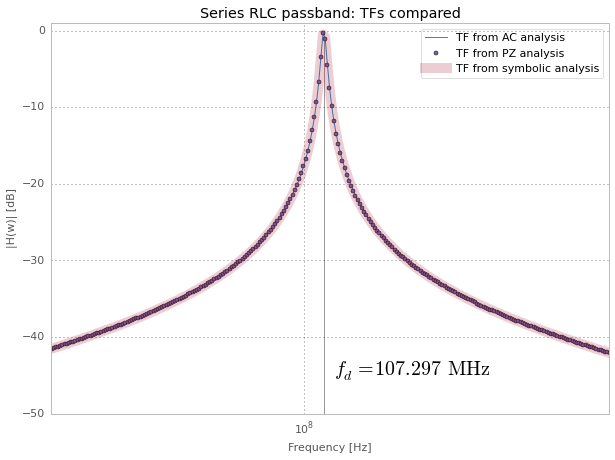

In [37]:
figure(figsize=figsize);  title('Series RLC passband: TFs compared')
semilogx(rac.get_x()/2/np.pi, dB20(abs(rac['vout'])), label='TF from AC analysis')
semilogx(rac.get_x()/2/np.pi, dB20(abs(Hl(rac.get_x()))), 'o', ms=4, label='TF from PZ analysis')
semilogx(rac.get_x()/2/np.pi, dB20(abs(HS(rac.get_x()))), '-', lw=10, alpha=.2, label='TF from symbolic analysis')
vlines(1.07297e+08, *gca().get_ylim(), alpha=.4)
text(7e8/2/np.pi, -45, '$f_d = 107.297\\, \\mathrm{MHz}$', fontsize=20)
legend(); xlabel('Frequency [Hz]'); ylabel('|H(w)| [dB]'); xlim(4e7, 3e8); ylim(-50, 1);

I hope this example helped show how to use [ahkab](https://ahkab.github.io/ahkab/) and in particular how to perform PZ, AC and symbolic analysis. If it also cleared up some doubts, great!

Please remember this is an experimental simulator and you may find bug... it's getting better bu we're not really ready for prime time yet: please report any and all bugs you may encounter on [the issue tracker](https://github.com/ahkab/ahkab/issues).